In [1]:
import joblib

filename = "Log/ppo1TFS-02262021-114243-victim/model/best_model_ppoadv_player0_traj.data"
trajectory_dic = joblib.load(filename)
    



In [2]:
trajectory_dic['all_obvs'].shape

(4000001, 13)

In [3]:
from utils.helper import pca_analysis,traj_stat_analysis
orig_observations,all_actions,all_dones,all_rewards,all_hidden = traj_stat_analysis(trajectory_dic)

(3999982, 13)
(3999982, 2)
(3999982,)
(3999982,)
(3999982, 8)
min obversations: [-1.04 -1.44 -1.01 -1.48 -1.03 -1.27 -1.01 -1.29 -0.88 -4.93 -0.99 -4.63
 -1.  ]
max obversations: [1.04 1.49 1.01 1.48 1.03 1.27 1.01 1.27 0.89 5.36 1.04 5.49 0.  ]
min actions: [-1. -1.]
max actions: [1. 1.]


In [4]:
logdir = "Log/ppo1TFS-02262021-114243-victim/model/"
profiling_folder = logdir + "profiling/"

n_components = 6
pcaModelPath = profiling_folder + "pcaModel_n{}.job".format(n_components)
pcaModel, pca_dic = pca_analysis(n_components,pcaModelPath,all_hidden,True)

Load saved pca model successfully!


In [5]:
import numpy as np
np.around(pca_dic['pca_data'][:10],4)

array([[-1.9819,  1.5097,  0.2601,  0.5986, -0.1241, -0.0087],
       [-0.832 , -1.3774, -0.9155, -0.9358, -0.6469,  0.0091],
       [-0.9237, -1.0346, -0.7607, -0.7166, -0.8788, -0.1098],
       [-0.8452, -1.3408, -0.871 , -0.9337, -0.665 ,  0.0179],
       [-0.8241, -1.4193, -0.9027, -0.9877, -0.6092,  0.0508],
       [-0.9302, -0.9543, -0.6907, -0.704 , -0.9293, -0.074 ],
       [-0.8993, -1.0948, -0.7178, -0.8254, -0.8053,  0.0134],
       [-1.0547, -0.5276, -0.4187, -0.4975, -1.1749, -0.1441],
       [-1.1453, -0.2135, -0.2978, -0.3293, -1.1945, -0.1368],
       [-1.2667,  0.0841, -0.2727, -0.1207, -1.0438, -0.1522]],
      dtype=float32)

In [6]:
from utils.helper import dtmc_abs_analysis
grid_num = 8
abs_profiling_file = profiling_folder + "profilingRes_g{}_n{}.dic".format(grid_num, n_components)
profiling_dic = dtmc_abs_analysis(pca_dic, None, grid_num,abs_profiling_file)


Load profiling results from Log/ppo1TFS-02262021-114243-victim/model/profiling/profilingRes_g8_n6.dic successfully!


In [7]:
dtmc = profiling_dic['dtmc']
abs_states = dtmc.state_abstract(con_states = pca_dic['pca_data'])

In [8]:
abs_traces, tracesLen, results = dtmc.extract_abs_trace(all_rewards,abs_states)

Total traces:39834
Success:33137
Failure:6697


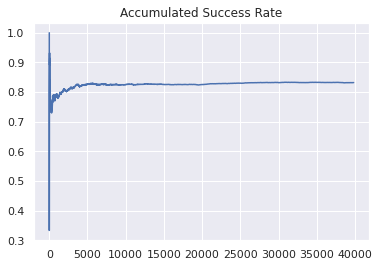

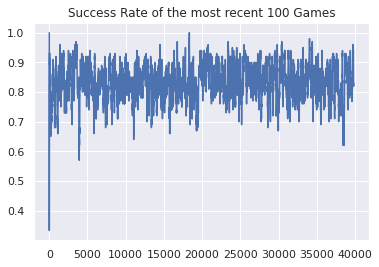

In [9]:
from utils.plot_func import plot_successRate
plot_successRate(results,True,title="Accumulated Success Rate")
plot_successRate(results,False, title="Success Rate of the most recent 100 Games")
# show_hist(np.array(profiling_dic['abs_states'],dtype=np.int32),bin=100,range=None,title="distribution of abstract states")

In [10]:
def calc_coverage(abs_states,grid_num,n_componenct):
    uniq = len(np.unique(np.array(abs_states)))
    total = pow(grid_num, n_componenct)
    print("The number of unique states:{}".format(uniq))
    print("The number of total states:{}".format(total))
    print("Coverage:{:.2f}".format((uniq*1.0)/total))

calc_coverage(abs_states,grid_num,n_components)

The number of unique states:9657
The number of total states:262144
Coverage:0.04


In [11]:
uniq_states = np.unique(np.array(profiling_dic['abs_states']))

In [12]:
new_uniq_states = np.unique(np.array(abs_states))

In [13]:
new_states = []
covered_states = []
for uniq in new_uniq_states:
    if uniq not in uniq_states:
        new_states.append(uniq)
    else:
        covered_states.append(uniq)

print("New trajectories covered {} old abstract states.".format(len(covered_states)))
print("New trajectories discovered {} new abstract states.".format(len(new_states)))

New trajectories covered 7376 old abstract states.
New trajectories discovered 2281 new abstract states.


In [14]:
from utils.helper import analyze_abstraction

In [15]:
avgFreq, abs2con, state_dic, transistion_dic = analyze_abstraction(abs_states, abs_traces)
occurance = []
for key,val in state_dic.items():
    occurance.append(val[0]+val[1])
occurance = np.array(sorted(occurance))
percent95 = int(np.percentile(occurance,95))
print("total covered states:",len(occurance))
print("when we choose avgFreq threshold (i.e.,{}) to filter rare states, only {} abstract states are kept.".format(
    int(avgFreq),len(np.where(occurance>avgFreq)[0])))
print("when we choose percent95 threshold (i.e.,{}) to filter rare states, only {} abstract states are kept.".format(
    percent95,len(np.where(occurance>percent95)[0])))

total covered states: 9657
when we choose avgFreq threshold (i.e.,414) to filter rare states, only 682 abstract states are kept.
when we choose percent95 threshold (i.e.,697) to filter rare states, only 483 abstract states are kept.


In [16]:
print("when we choose profiling percent95 threshold (i.e.,680) to filter rare states, only {} abstract states are kept.".format(
    len(np.where(occurance>680)[0])))

when we choose profiling percent95 threshold (i.e.,680) to filter rare states, only 496 abstract states are kept.


In [18]:
from utils.helper import fetchCriticalState

savepath = profiling_folder + "ppo1adv_test_critical_states.dic"
critical, good_list, bad_list = fetchCriticalState(state_dic, 680, threshold=0.35, savepath=savepath)

good state: 435
bad state: 12
Save critical states info to  Log/ppo1TFS-02262021-114243-victim/model/profiling/ppo1adv_test_critical_states.dic


In [19]:
import joblib

loadpath = profiling_folder + "critical_states.dic"
critical_dic = joblib.load(loadpath)


In [20]:
for bad in critical_dic['bad_list']:
    if bad in bad_list:
        print(bad,True)
    else:
        print(bad)

47300
108982
141750
80069
83680
109799
178227


In [21]:
for good in critical_dic['good_list']:
    if good in good_list:
        print(good,True)
    else:
        print(good)

170027 True
169516 True
111783 True
137259 True
109097 True
169507 True
169515 True
173258 True
173165 True
108122 True
108578 True
173092 True
173091 True
172572 True
140379 True
172571 True
173677 True
47201 True
169508 True
140398 True
47193 True
109089 True
168995 True
136739 True
140910 True
172635 True
173083 True
145603 True
109098
137251 True
145098
140995 True
